In [4]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

#define utility functions

#this simulate a circuit (without measurement) and output results in the format of histogram.
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)




def encode_cirq(image):
    circuit=cirq.Circuit()
    if image[0][0]==0:
        circuit.append(cirq.rx(np.pi).on(cirq.LineQubit(0)))
    return circuit

def encode_qiskit(image, size):
    n = int(np.log2(size*size)) + 1
    q = qiskit.QuantumRegister(n)
    circuit = qiskit.QuantumCircuit(q)
    initState(circuit, range(0,n), image, size, n)
    
    return circuit.decompose(5)


def decode(histogram, size):
    image = np.array([[0.00] * size] * size) 
    for (key, value) in histogram.items():
        image[int(key / size)][key % size] =  value
        
    return image

def initState(qc, qubits, state, size, n):
    
    vec = np.array(state).flatten()
    leftOver = (2**n) - size*size
    vec = np.pad(vec, (0, leftOver), 'constant')
    print(vec.size)
    norm = np.absolute(vec).sum()
    normState = []
    for i in range(0, vec.size):
        normState.append(float((1 if vec[i] >= 0 else -1) * np.sqrt(np.absolute(vec[i]))) / np.sqrt(norm))
    qc.initialize(normState, qubits)
    return "norm"


[0.         0.         0.         0.         0.         0.
 0.         0.         0.00059977 0.00138408 0.00207612 0.00307574
 0.00202999 0.00092272 0.00098424 0.00127643 0.0028143  0.00299885
 0.00149173 0.00044598 0.         0.         0.         0.
 0.         0.         0.         0.        ]


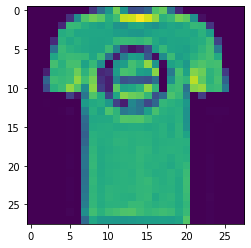

In [2]:
#load data
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)
import matplotlib.pyplot as plt 
images=np.load('data/images.npy')
# data = images[0][0:16, 0:16]
data = images[0]
plt.imshow(data)
print(data[0])
dataset = [{"image": data}]

1024
Created
784
0.45639698215109326


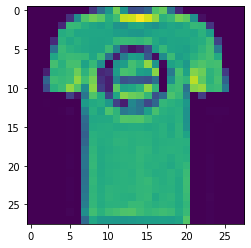

In [5]:
#grade part1

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    #encode image into circuit
    circuit=encode_qiskit(data['image'], 28)
    print("Created")
    #simulate circuit
    histogram=simulate(circuit)
    gatecount += 28*28 # Just a guess
    
    #reconstruct 
    image_re=decode(histogram, 28)
    plt.imshow(image_re)
    
    #calculate mse
    mse+=image_mse(np.asarray(data['image']),np.asarray(image_re))
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))

In [21]:
#grade part 2

#load classifier circuit
classifier=qiskit.QuantumCircuit.from_qasm_file('part2.qasm')
    
score=0

for data in dataset:
    #encode image into circuit
    circuit=encode_qiskit(data['image'])
    
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))

    gatecount+=count_gates(qc)[2]
    
    #simulate circuit
    histogram=simulate(qc)
    
    #convert histogram to category
    cat=histogram_to_category(histogram)
    
    
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

1.0
